# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_processed/data.csv')

data.drop('loan_id', axis=1, inplace=True)

features = data.drop('status', axis=1).values
target = data['status'].values
print(data)
print(target)


results = {}

     account_id  amount  duration  payments  status  client_id  district_id  \
0          1787   96396        12      8033      -1       2166           30   
1          1801  165960        36      4610       1       2181           46   
2          9188  127080        60      2118       1      11314           45   
3          1843  105804        36      2939       1       2235           14   
4         11013  274740        60      4579       1      13539           63   
..          ...     ...       ...       ...     ...        ...          ...   
323        9030  155616        48      3242       1      11121           72   
324        3189  222180        60      3703      -1       3855           29   
325        8972   45024        48       938       1      11050           70   
326       10963  115812        36      3217       1      13480           16   
327       11362  129408        24      5392       1      13971           67   

     gender  disp_id  has_disponent  age_on_loan_re

In [2]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(features, target, test_size=0.25, random_state=1)

In [3]:
def add_model(name, model):
    model.fit(training_inputs, training_classes)
    results[name] = {'model': model}

In [4]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier()
)

In [5]:
from sklearn.ensemble import RandomForestClassifier
add_model('rf',
    RandomForestClassifier()
)

In [6]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True)
)

In [7]:
def predict(name):
    pred = results[name]['model'].predict(testing_inputs)
    results[name]['pred'] = pred

predict('dtc')
predict('rf')
predict('svc')

In [8]:
def predict_proba(name):
    proba = results[name]['model'].predict_proba(testing_inputs)
    results[name]['pred_prob'] = proba

predict_proba('dtc')
predict_proba('rf')
predict_proba('svc')


## Evaluation

In [9]:
def recall(cm, i):
    return cm[i][i]/sum(cm[i])

def precision(cm, i):
    cmt = np.copy(cm).transpose()
    return cmt[i][i]/sum(cmt[i])

def f_measure(cm, i):
    p = precision(cm, i)*100
    r = recall(cm, i)*100
    return 2 * (p * r) / (p + r)

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(testing_classes, predicted_classes):
    cm =  confusion_matrix(testing_classes, predicted_classes)
    '''
    print("TP:", cm[1][1])
    print("TN:", cm[0][0])
    print("FP:", cm[0][1])
    print("FN:", cm[1][0])
    '''
    ConfusionMatrixDisplay(cm, display_labels=[-1, 1]).plot()

In [11]:
def score(name):
    results[name]['score'] = results[name]['model'].score(testing_inputs, testing_classes)
    print(name.upper()+":", results[name]['score'])

score('dtc')
score('rf')
score('svc')

DTC: 0.7073170731707317
RF: 0.8780487804878049
SVC: 0.8780487804878049


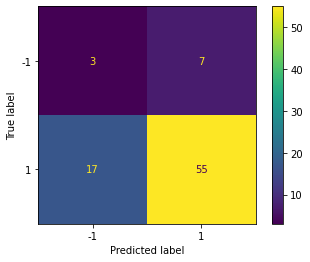

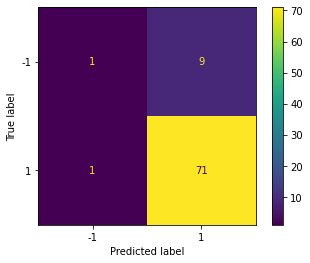

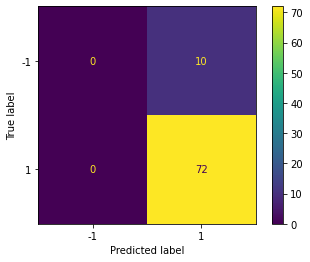

In [12]:
conf_matrix(testing_classes, results['dtc']['pred'])
conf_matrix(testing_classes, results['rf']['pred'])
conf_matrix(testing_classes, results['svc']['pred'])

0.5319444444444444
0.7180555555555556
0.5375000000000001


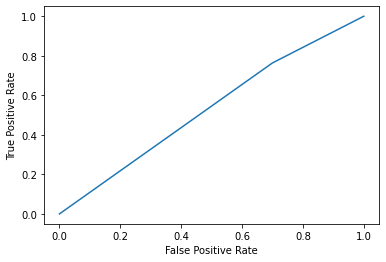

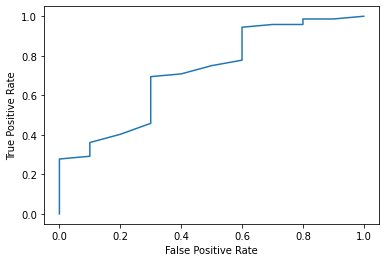

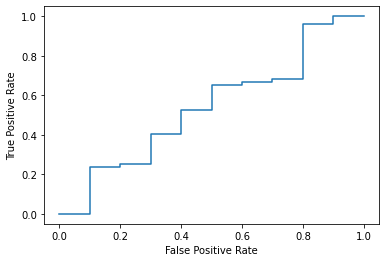

In [13]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

def roc_and_auc(name):
    fpr, tpr, _ = roc_curve(testing_classes, results[name]['pred_prob'][:,-1], pos_label=results[name]['model'].classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print(auc(fpr, tpr))

roc_and_auc('dtc')
roc_and_auc('rf')
roc_and_auc('svc')

In [14]:
print(results)

{'dtc': {'model': DecisionTreeClassifier(), 'pred': array([ 1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1]), 'pred_prob': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1